In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray import DataArray
import pandas as pd
from PyEMD import EEMD
import pylab as plt

In [2]:
data       = xr.open_dataset("/work/uo1075/u241321/data/EN4_t_ym_remap_NA560.nc",decode_times=False) 
data

<xarray.Dataset>
Dimensions:      (time: 50, lon: 150, lat: 90, depth: 19)
Coordinates:
  * time         (time) float32 6.227e+04 6.264e+04 ... 7.98e+04 8.017e+04
  * lon          (lon) float64 -79.5 -78.5 -77.5 -76.5 ... 66.5 67.5 68.5 69.5
  * lat          (lat) float64 0.5 1.5 2.5 3.5 4.5 ... 85.5 86.5 87.5 88.5 89.5
  * depth        (depth) float32 6.0 17.0 27.0 37.0 ... 362.5 420.0 485.0 560.0
Data variables:
    temperature  (time, depth, lat, lon) float32 ...

In [4]:
data       = xr.open_dataset("/work/uo1075/u241321/data/EN4_t_ym_remap_NA560.nc",decode_times=False) 

lat_min, lat_max = (60,76) # Norwegian Sea
lon_min, lon_max = (0,20)

var11 = data['temperature'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
var1 = np.mean(var11[:,0:15,:,:], axis=1)

# weight average 
weights = np.cos(np.deg2rad(var1.lat))
weights.name = "weights"
air_weighted = var1.weighted(weights)
y = air_weighted.mean(("lon", "lat"))
# Assign EEMD to `eemd` variable
S = y.values
t = np.arange(1970,2020,1)

# EEMD options
max_imf=3
# Prepare and run EEMD
eemd = EEMD(trials=10000, FIXE_H=10, DTYPE=np.float16, noise_width=0.2, parallel=True)   #max_imfs=10)
eemd.noise_seed(6021)

# Execute EEMD on S
eIMFs = eemd.eemd(S, t, max_imf)
nIMFs = eIMFs.shape[0]

imfs, residue = eemd.get_imfs_and_residue() # imfs: same as eIMFs; residue = input - np.sum(eIMFs, axis=0)

# Whitenoise statistical significance test.
# Performs whitenoise test as described by Wu & Huang [Wu2004].
from PyEMD.checks import whitenoise_check
significant_imfs = whitenoise_check(eIMFs, test_name='apriori', alpha=0.99)
significant_imfs   # {1: 1, 2: 1, 3: 1, 4: 0}


{1: 1, 2: 1, 3: 0, 4: 0}

In [5]:
assi = np.zeros((5,50))  #  raw input data;  c1-c4
assi [0,:] = S
assi [1::,:] = eIMFs


In [10]:
assi1 = np.load("/work/uo1075/u241321/data/eemd_t310_assi_Norwegian.npy")
assi1.shape

(5, 50)

In [8]:
np.corrcoef(assi[0,:], assi1[0,:])[0,1]

0.9405379279292692

In [9]:
np.corrcoef(assi[1,:], assi1[1,:])[0,1]

0.8902129143053835

In [12]:
np.save("/work/uo1075/u241321/data/eemd_t310_assi_Norwegian_en4", assi)
# np.save("/work/uo1075/u241321/data/eemd_t310_h_ly2-5_Norwegian", eemd_h)

In [11]:
np.corrcoef(assi[2,:], assi1[2,:])[0,1]

0.8714848308615709

0.8953448807062457

In [4]:
np.corrcoef(assi[1,:], hind[1,:])[0,1]

0.9999999999999998

In [5]:
np.corrcoef(assi[2,:], hind[2,:])[0,1]

1.0

In [6]:
np.corrcoef(assi[3,:], hind[3,:])[0,1]

1.0

In [16]:
np.corrcoef(assi[4,:], hind[4,:])[0,1]

0.97818728914262

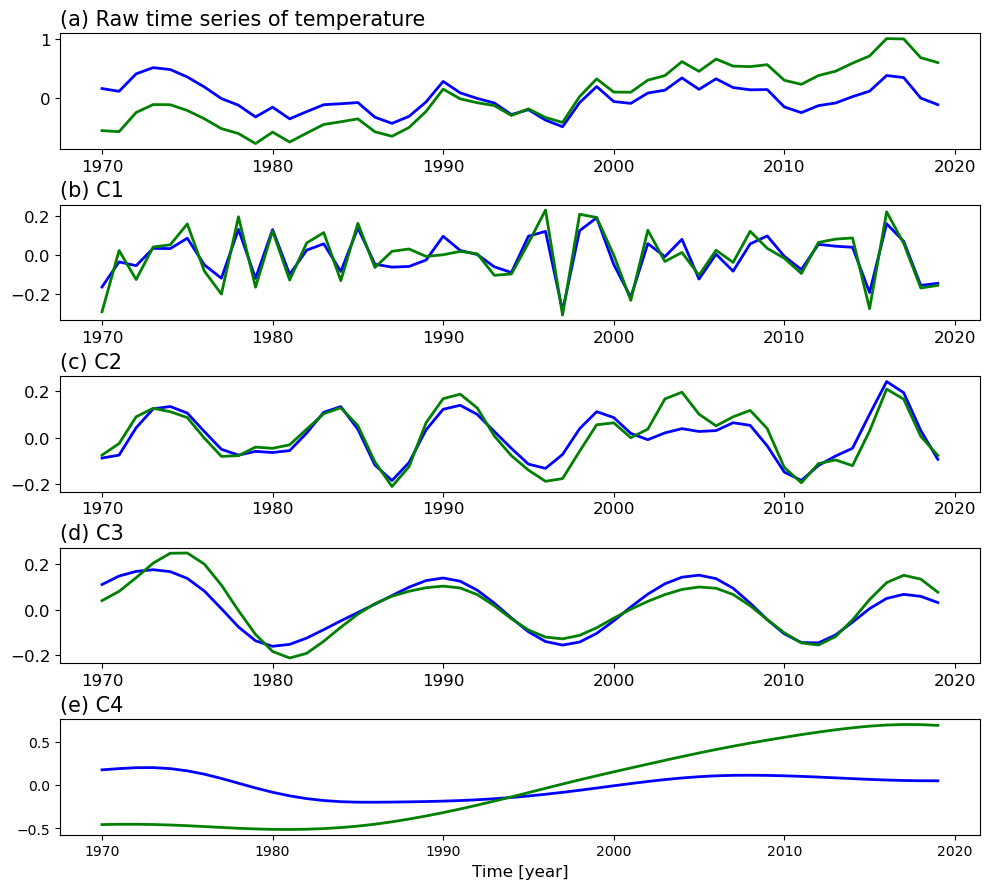

In [17]:
import matplotlib.pyplot as plt
t = np.arange(1970,2020,1)
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 9))
fontsize = 15
#plot time signal:
axs[0].set_title("(a) Raw time series of temperature ", loc='left', fontsize=fontsize)
axs[0].plot(t, assi[0,:], 'b', linewidth=2)
axs[0].plot(t, hind[0,:], '-', color='green', linewidth=2, markersize=10, label = 'Raw')

# axs[0].set_xticklabels([])
plt.title('(a)', loc='left', fontsize=fontsize)

axs[1].plot(t, assi[1,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[1].plot(t, hind[1,:], '-', color='green', linewidth=2, markersize=10)
axs[1].set_title("(b) C1", loc='left', fontsize=fontsize)
# axs[1].set_ylim(-0.05, 0.05)   

axs[2].plot(t, assi[2,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[2].plot(t, hind[2,:], '-', color='green', linewidth=2, markersize=10)
axs[2].set_title("(c) C2", loc='left', fontsize=fontsize)

axs[3].plot(t, assi[3,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[3].plot(t, hind[3,:], '-', color='green', linewidth=2, markersize=10)
axs[3].set_title("(d) C3", loc='left', fontsize=fontsize)

axs[4].plot(t, assi[4,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[4].plot(t, hind[4,:], '-', color='green', linewidth=2, markersize=10)
axs[4].set_title("(e) C4", loc='left', fontsize=fontsize)
# axs[4].set_ylim(-0.05, 0.05)

axs[4].set_xlabel("Time [year]", fontsize='12')

axs[0].tick_params(axis='both', labelsize=12)
axs[1].tick_params(axis='both', labelsize=12)
axs[2].tick_params(axis='both', labelsize=12)
axs[3].tick_params(axis='both', labelsize=12)



# axs[6].set_ylim(-0.05, 0.05)
plt.tight_layout(h_pad=0.5, w_pad=None)

fig.savefig('/work/uo1075/u241321/results/results.pdf',bbox_inches='tight')

plt.show()

In [16]:
nao = np.load("/work/uo1075/u241321/data/eemd_NAO_slp.npy")
spg = np.load("/work/uo1075/u241321/data/EEMD_spg_density.npy")
s_assi = np.load("/work/uo1075/u241321/data/eemd_s_Norwegian.npy")
nao.shape

(5, 50)

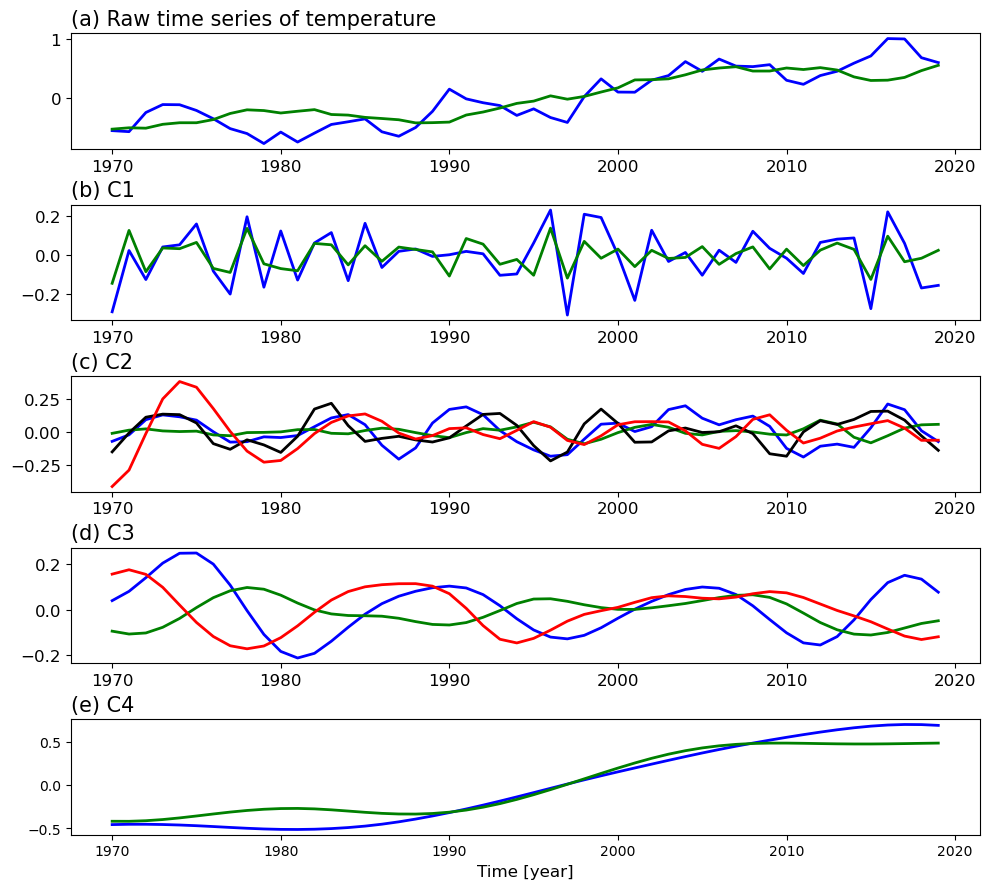

In [20]:
import matplotlib.pyplot as plt
t = np.arange(1970,2020,1)
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 9))
fontsize = 15
#plot time signal:
axs[0].set_title("(a) Raw time series of temperature ", loc='left', fontsize=fontsize)
axs[0].plot(t, assi[0,:], 'b', linewidth=2)
axs[0].plot(t, hind[0,:], '-', color='green', linewidth=2, markersize=10, label = 'Raw')

# axs[0].set_xticklabels([])
plt.title('(a)', loc='left', fontsize=fontsize)

axs[1].plot(t, assi[1,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[1].plot(t, hind[1,:], '-', color='green', linewidth=2, markersize=10)
axs[1].set_title("(b) C1", loc='left', fontsize=fontsize)
# axs[1].set_ylim(-0.05, 0.05)   

axs[2].plot(t, assi[2,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[2].plot(t, hind[2,:], '-', color='green', linewidth=2, markersize=10)
axs[2].plot(t, nao[2,:]/10., '-', color='black', linewidth=2, markersize=10)
axs[2].plot(t, spg[2,:]*10., '-', color='red', linewidth=2, markersize=10)
axs[2].set_title("(c) C2", loc='left', fontsize=fontsize)

axs[3].plot(t, assi[3,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[3].plot(t, hind[3,:], '-', color='green', linewidth=2, markersize=10)
axs[3].plot(t, s_assi[3,:]*10, '-', color='red', linewidth=2, markersize=10)

axs[3].set_title("(d) C3", loc='left', fontsize=fontsize)

axs[4].plot(t, assi[4,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[4].plot(t, hind[4,:], '-', color='green', linewidth=2, markersize=10)
axs[4].set_title("(e) C4", loc='left', fontsize=fontsize)
# axs[4].set_ylim(-0.05, 0.05)

axs[4].set_xlabel("Time [year]", fontsize='12')

axs[0].tick_params(axis='both', labelsize=12)
axs[1].tick_params(axis='both', labelsize=12)
axs[2].tick_params(axis='both', labelsize=12)
axs[3].tick_params(axis='both', labelsize=12)



# axs[6].set_ylim(-0.05, 0.05)
plt.tight_layout(h_pad=0.5, w_pad=None)

fig.savefig('/work/uo1075/u241321/results/results.pdf',bbox_inches='tight')

plt.show()

In [10]:
np.corrcoef(assi[2,:], assi1[2,:])[0,1]

0.49558871813322086

In [11]:
np.corrcoef(assi[3,:], assi1[3,:])[0,1]

0.7386294864416603

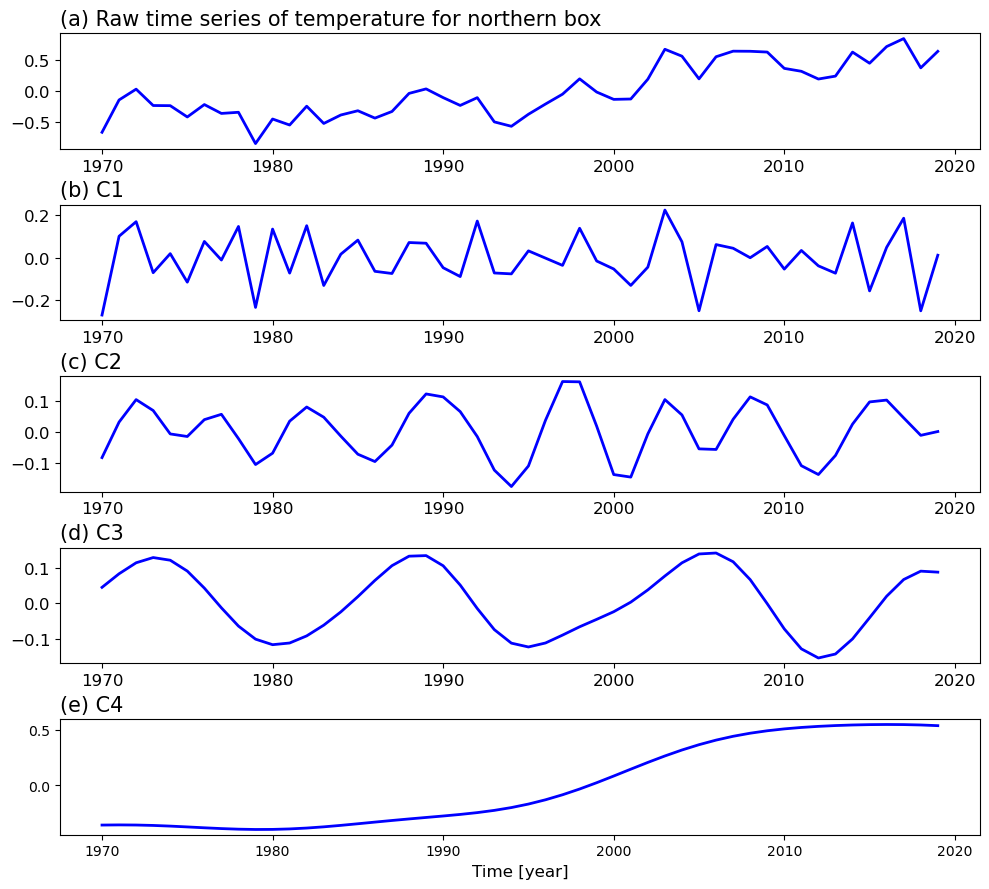

In [9]:
import matplotlib.pyplot as plt
t = np.arange(1970,2020,1)
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 9))
fontsize = 15
#plot time signal:
axs[0].set_title("(a) Raw time series of temperature for northern box", loc='left', fontsize=fontsize)
axs[0].plot(t, assi1[0,:], 'b', linewidth=2)
# axs[0].plot(t, hind[0,:], '-', color='green', linewidth=2, markersize=10, label = 'Raw')

# axs[0].set_xticklabels([])
plt.title('(a)', loc='left', fontsize=fontsize)

axs[1].plot(t, assi1[1,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
# axs[1].plot(t, hind[1,:], '-', color='green', linewidth=2, markersize=10)
axs[1].set_title("(b) C1", loc='left', fontsize=fontsize)
# axs[1].set_ylim(-0.05, 0.05)   

axs[2].plot(t, assi1[2,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
# axs[2].plot(t, hind[2,:], '-', color='green', linewidth=2, markersize=10)
axs[2].set_title("(c) C2", loc='left', fontsize=fontsize)

axs[3].plot(t, assi1[3,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
# axs[3].plot(t, hind[3,:], '-', color='green', linewidth=2, markersize=10)
axs[3].set_title("(d) C3", loc='left', fontsize=fontsize)

axs[4].plot(t, assi1[4,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
# axs[4].plot(t, hind[4,:], '-', color='green', linewidth=2, markersize=10)
axs[4].set_title("(e) C4", loc='left', fontsize=fontsize)
# axs[4].set_ylim(-0.05, 0.05)

axs[4].set_xlabel("Time [year]", fontsize='12')

axs[0].tick_params(axis='both', labelsize=12)
axs[1].tick_params(axis='both', labelsize=12)
axs[2].tick_params(axis='both', labelsize=12)
axs[3].tick_params(axis='both', labelsize=12)



# axs[6].set_ylim(-0.05, 0.05)
plt.tight_layout(h_pad=0.5, w_pad=None)

# fig.savefig('/work/uo1075/u241321/results/results.pdf',bbox_inches='tight')

plt.show()

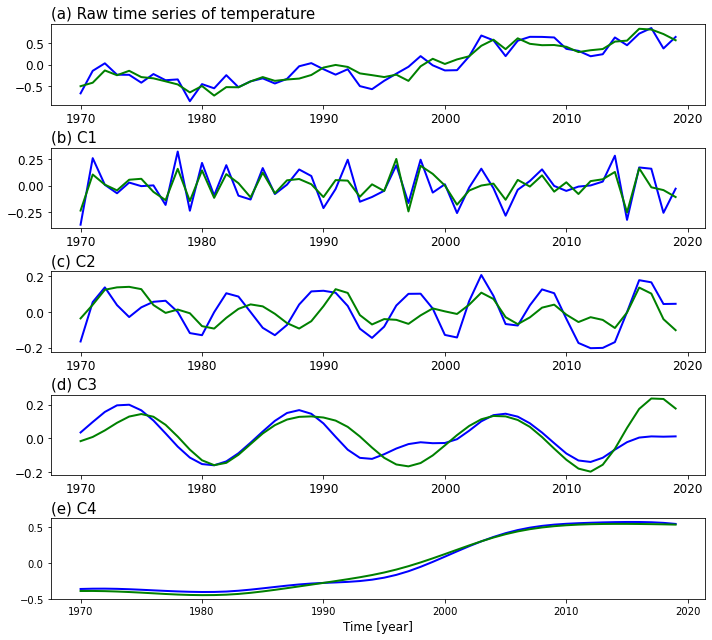

In [12]:
import matplotlib.pyplot as plt
t = np.arange(1970,2020,1)
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 9))
fontsize = 15
#plot time signal:
axs[0].set_title("(a) Raw time series of temperature ", loc='left', fontsize=fontsize)
axs[0].plot(t, assi1[0,:], 'b', linewidth=2)
axs[0].plot(t, assi[0,:], '-', color='green', linewidth=2, markersize=10, label = 'Raw')

# axs[0].set_xticklabels([])
plt.title('(a)', loc='left', fontsize=fontsize)

axs[1].plot(t, assi1[1,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[1].plot(t, assi[1,:], '-', color='green', linewidth=2, markersize=10)
axs[1].set_title("(b) C1", loc='left', fontsize=fontsize)
# axs[1].set_ylim(-0.05, 0.05)   

axs[2].plot(t, assi1[2,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[2].plot(t, assi[2,:], '-', color='green', linewidth=2, markersize=10)



axs[2].set_title("(c) C2", loc='left', fontsize=fontsize)

axs[3].plot(t, assi1[3,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[3].plot(t, assi[3,:], '-', color='green', linewidth=2, markersize=10)
axs[3].set_title("(d) C3", loc='left', fontsize=fontsize)

axs[4].plot(t, assi1[4,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[4].plot(t, assi[4,:], '-', color='green', linewidth=2, markersize=10)
axs[4].set_title("(e) C4", loc='left', fontsize=fontsize)
# axs[4].set_ylim(-0.05, 0.05)

axs[4].set_xlabel("Time [year]", fontsize='12')

axs[0].tick_params(axis='both', labelsize=12)
axs[1].tick_params(axis='both', labelsize=12)
axs[2].tick_params(axis='both', labelsize=12)
axs[3].tick_params(axis='both', labelsize=12)



# axs[6].set_ylim(-0.05, 0.05)
plt.tight_layout(h_pad=0.5, w_pad=None)

# fig.savefig('/work/uo1075/u241321/results/results.pdf',bbox_inches='tight')

plt.show()